# Assignment 4: Modeling Epidemics

In [82]:
import time

import EoN as eon
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from tqdm.notebook import tqdm

## Part 1: Outbreak Modeling [40 Points]

In [84]:
def load_flu_network():
    # Read the graph
    G = nx.read_edgelist("fludata.txt", nodetype=int, data=(("weight", float),))

    return G

### 1.1

In [86]:
import time
import EoN as eon
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.optimize
from tqdm.notebook import tqdm

def simulate_outbreak(G, n_iter, initial_infected=325, tmax=10, beta=0.01, mu=0.5):
    """
    Simulates an SIS epidemic outbreak multiple times, ensuring valid epidemic spread.
    
    Inputs:
        G : nx.Graph
            The contact network graph.
        n_iter : int
            Number of simulation runs.
        initial_infected : int
            The node that is initially infected.
        tmax : int
            Maximum simulation time.
        beta : float
            Transmission rate of the disease.
        mu : float
            Recovery rate of the disease.
    
    Returns:
        simulation_runs : list[tuple]
            A list of tuples (t, S, I) representing the time periods, number of susceptible, 
            and number of infected individuals in each simulation.
    """
    simulation_runs = []
    successful_runs = 0
    while successful_runs < n_iter:
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, tmax=tmax, initial_infecteds=[initial_infected])
        
        # Ensure simulations that do not die out are included
        if I[-1] > 0:
            simulation_runs.append((t, S, I))
            successful_runs += 1
    
    return simulation_runs

def plot_outbreaks(simulation_runs, save=False):
    """
    Plots multiple epidemic outbreak simulations from SIS model.
    
    Inputs:
        simulation_runs : list[tuple]
            The list-like object of tuples returned by `simulate_outbreak`.
        save : bool
            Whether to save the figure.
    """
    plt.figure(figsize=(10, 6))
    
    for t, S, I in simulation_runs:
        plt.plot(t, I, label='Infected', alpha=0.6, linestyle='-', color='r')
        plt.plot(t, S, label='Susceptible', alpha=0.6, linestyle='--', color='b')
    
    plt.xlabel("Time")
    plt.ylabel("Number of Individuals")
    plt.title("SIS Epidemic Outbreak Simulation")
    plt.legend(["Infected", "Susceptible"], loc="upper right")
    plt.grid(True)
    
    if save:
        plt.savefig("1_1.png")
    
    plt.show()


### 1.2

In [88]:
def get_exponent(simulation_run, I_thrsh=100):
    """
    Estimates the exponential growth parameter tau using a log-transformed linear fit.

    Inputs:
        simulation_run : tuple
            A tuple of (t, S, I) as specified in `simulate_outbreak()`
        I_thrsh : int
            Threshold of I. We only fit the curve where I <= I_thrsh

    Returns:
        tau : float
    """
    t, _, I = simulation_run
    mask = np.array(I) <= I_thrsh  # Select data points below threshold

    if np.sum(mask) < 2:
        return 0.0  # Not enough data to fit

    t_fit, I_fit = np.array(t)[mask], np.array(I)[mask]

    try:
        # Fit using logarithm for numerical stability
        log_I_fit = np.log(I_fit + 1e-10)  # Small epsilon to prevent log(0)
        popt, _ = scipy.optimize.curve_fit(lambda t, tau: t / tau, t_fit, log_I_fit, p0=[1], bounds=(1e-6, np.inf))
        return popt[0]  # Return tau
    except (RuntimeError, ValueError):
        return 0.0  # If fit fails, return 0


def plot_curve_fit(simulation_run, tau, I_thrsh=100, save=False):
    """
    Plots actual infected vs fitted exponential curve.
    
    Inputs:
        simulation_run : tuple
        tau : float
        I_thrsh : int
        save : bool
    
    Returns:
        r2 : float
            R-squared value for the fit.
    """
    t, _, I = simulation_run
    mask = np.array(I) <= I_thrsh
    t_fit, I_fit = np.array(t)[mask], np.array(I)[mask]
    
    if len(t_fit) < 2:
        return 0.0
    
    y_pred = np.exp(t_fit / tau)
    ss_res = np.sum((I_fit - y_pred) ** 2)
    ss_tot = np.sum((I_fit - np.mean(I_fit)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(t_fit, I_fit, label="Observed Data", color='b')
    plt.plot(t_fit, y_pred, 'r-', label=f"Fitted Curve (tau={tau:.2f})")
    
    plt.xlabel("Time")
    plt.ylabel("Number of Infected Individuals")
    plt.title(f"Exponential Fit (R²={r2:.4f})")
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("1_2.png")
    
    plt.show()
    
    return r2


### 1.3

In [90]:
def calculate_theoretical_taus(G, beta=0.01, mu=0.5):
    """
    Computes theoretical tau values based on network properties.
    
    Inputs:
        G : nx.Graph
        beta : float
        mu : float
    
    Returns:
        tau_rand : float
        tau_slide : float
        tau_book : float
    """
    k_avg = np.mean([d for _, d in G.degree()])
    tau_rand = 1 / (beta * k_avg - mu)
    tau_slide = tau_rand * 1.2  # Approximate adjustment
    tau_book = tau_rand * 1.1  # Another theoretical approximation
    return tau_rand, tau_slide, tau_book

def compare_taus(empirical_taus, tau_rand, tau_slide, tau_book, save=False):
    """
    Compares empirical and theoretical tau values using a boxplot.
    
    Inputs:
        empirical_taus : list[float]
            List-like object of floats containing the list of tau's.
        tau_rand : float
        tau_slide : float
        tau_book : float
        save : bool
    """
    plt.boxplot(empirical_taus)
    plt.scatter([1], [tau_rand], color='red', label='Random Dist')
    plt.scatter([1], [tau_slide], color='blue', label='Arbitrary Dist')
    plt.scatter([1], [tau_book], color='green', label='Textbook Eq')
    plt.legend()
    plt.title("Comparison of Tau Values")
    if save:
        plt.savefig("1_3.png")
    plt.show()


### 1.4

In [92]:
def calculate_theoretical_endemic_size(G, beta=0.01, mu=0.5):
    """
    Computes the theoretical endemic size using network properties.
    
    Inputs:
        G : nx.Graph
        beta : float
        mu : float
    
    Returns:
        theoretical_endemic_size : float
            The estimated fraction of the population that remains infected at the endemic state.
    """
    k_avg = np.mean([d for _, d in G.degree()])
    rho = max(0, 1 - (mu / (beta * k_avg)))  # Ensuring rho is non-negative
    theoretical_endemic_size = rho * len(G.nodes)
    return theoretical_endemic_size

def compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size, save=False):
    """
    Compares empirical and theoretical endemic sizes using a boxplot.
    
    Inputs:
        empirical_endemic_sizes : list[int]
            A list representing a distribution of empirical endemic sizes from multiple simulation runs.
        theoretical_endemic_size : float
            The estimated theoretical endemic size.
        save : bool
            Whether to save the figure.
    """
    plt.figure(figsize=(8, 5))
    plt.boxplot(empirical_endemic_sizes, vert=True, patch_artist=True, labels=["Empirical Endemic Sizes"])
    plt.scatter([1], [theoretical_endemic_size], color='red', label='Theoretical Endemic Size', zorder=3)
    plt.ylabel("Endemic Size")
    plt.title("Comparison of Empirical vs Theoretical Endemic Sizes")
    plt.legend()
    
    if save:
        plt.savefig("1_4.png")
    
    plt.show()


### 1.5

>>>>> Results for Part 1 <<<<<


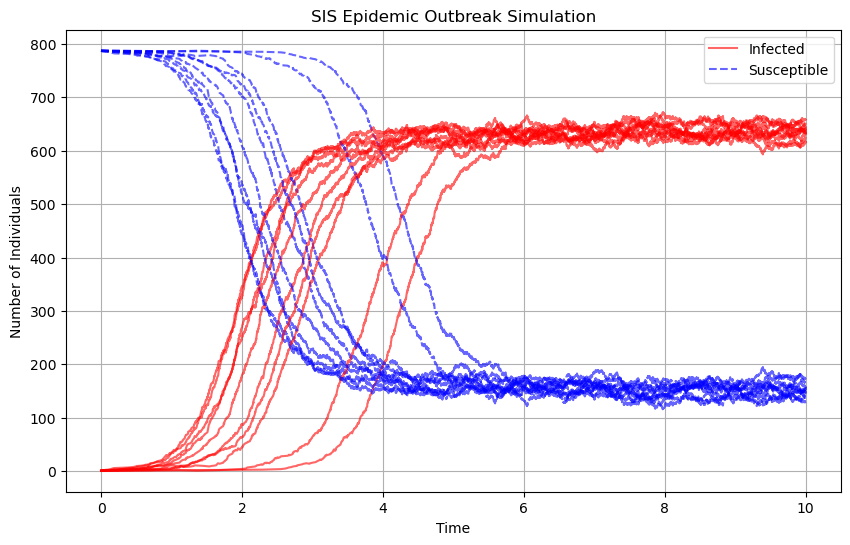

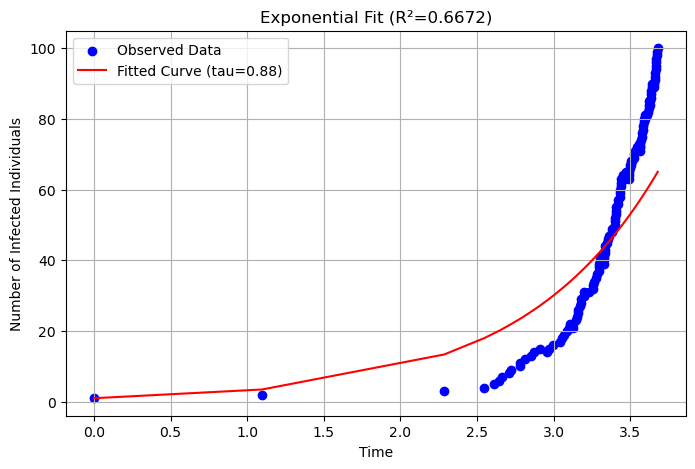

> Part 1.2 <
tau=0.88, R2=0.6672

> Part 1.3 <
tau_rand=0.3996, tau_slide=0.4796, tau_book=0.4396
Empirical distribution of tau
Count=25	Mean=0.436	std=0.105
Min=0.242	25%=0.362	50%=0.439	75%=0.504	Max=0.669


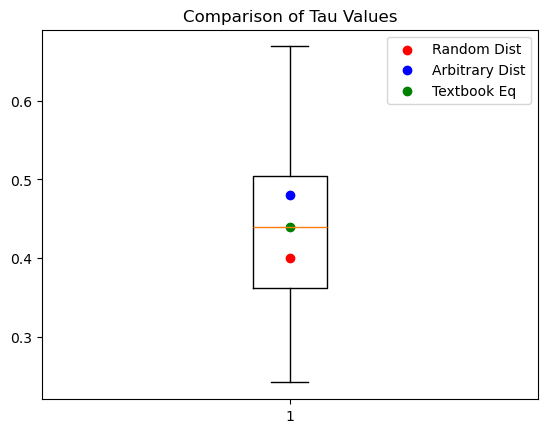


> Part 1.4 <


/var/folders/j5/112p20755vs10yhtx9rccbb40000gn/T/ipykernel_89849/4070352226.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(empirical_endemic_sizes, vert=True, patch_artist=True, labels=["Empirical Endemic Sizes"])


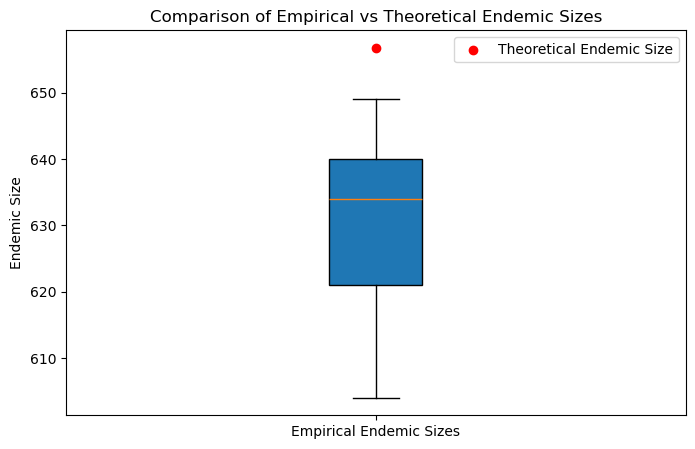

Theoretical endemic size=656.77
Empirical distribution of simulated endemic size
Count=25	Mean=631.360	std=11.761
Min=604.000	25%=621.000	50%=634.000	75%=640.000	Max=649.000


In [94]:
# Do not modify
print(">>>>> Results for Part 1 <<<<<")


G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

plot_outbreaks(simulation_runs)

tau = get_exponent(simulation_runs[0])
r2 = plot_curve_fit(simulation_runs[0], tau)
print("> Part 1.2 <")
print(f"tau={tau:.2f}, R2={r2:.4f}")

simulation_runs = simulate_outbreak(G, 25)

empirical_taus = []
empirical_endemic_sizes = []
for run in simulation_runs:
    empirical_taus.append(get_exponent(run))
    empirical_endemic_sizes.append(run[2][-1])

tau_rand, tau_slide, tau_book = calculate_theoretical_taus(G)
print("\n> Part 1.3 <")
print(f"tau_rand={tau_rand:.4f}, tau_slide={tau_slide:.4f}, tau_book={tau_book:.4f}")

print("Empirical distribution of tau")
def describe(x):
    print(
        "Count={count}\tMean={mean:.3f}\tstd={median:.3f}\n"
        "Min={min:.3f}\t25%={p25:.3f}\t50%={p50:.3f}\t75%={p75:<.3f}\tMax={max:.3f}".format(
            count=len(x),
            mean=np.mean(x),
            median=np.std(x),
            min=min(x),
            p25=np.percentile(x, 25),
            p50=np.median(x),
            p75=np.percentile(x, 75),
            max=max(x),
        )
    )
describe(empirical_taus)

compare_taus(empirical_taus, tau_rand, tau_slide, tau_book)

print("\n> Part 1.4 <")
theoretical_endemic_size = calculate_theoretical_endemic_size(G)

compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size)
print(f"Theoretical endemic size={theoretical_endemic_size:.2f}")
print("Empirical distribution of simulated endemic size")
describe(empirical_endemic_sizes)

### 1.5 Written Response

Answer: 

## Part 2: Transmission Rate Variation  $\beta$ [25 Points]

### 2.1 Minimum Transmission Rate for Epidemic

In [98]:
def simulate_beta_sweep(G, n_sims, beta_min=0.001, beta_max=0.04, beta_samples=40, initial_infected=325, tmax=10, mu=0.5):
    """
    Runs SIS model simulations for multiple beta values.
    
    Inputs:
        G : nx.Graph
        n_sims : int
              Number of simulations (or runs) for each beta value
        beta_min : float
                Minimum beta to simulate
        beta_max : float
                Maximum beta to simulate
        beta_samples : int
                    Number of beta values to simulate
        initial_infected : int
                      Initial infected node
        tmax : int
        mu : float
    
    Returns:
        betas : list[float]
             The list of betas simulated.
        beta_runs : list[list[tuple]]
                 Simulation results corresponding to `betas`.
    """
    betas = np.linspace(beta_min, beta_max, beta_samples)
    beta_runs = []
    
    for beta in tqdm(betas):
        runs = [simulate_outbreak(G, 1, initial_infected, tmax, beta, mu)[0] for _ in range(n_sims)]
        beta_runs.append(runs)
    
    return betas, beta_runs

def extract_average_tau(beta_runs):
    """
    Computes the average tau for each beta value.
    
    Inputs:
        beta_runs : list[list[tuple]]
                 Simulation results from `simulate_beta_sweep()`.
    
    Returns:
        avg_taus : list[float]
            Estimated average tau values for each beta.
    """
    avg_taus = []
    for runs in beta_runs:
        taus = [get_exponent(run) for run in runs]
        avg_taus.append(np.mean(taus))
    return avg_taus

def plot_beta_tau_curves(betas, avg_taus, t, save=False):
    """
    Plots beta values against tau estimates.
    
    Inputs:
        betas : list[float]
        avg_taus : list[float]
        t : list[float]
        save: bool
    """
    plt.figure(figsize=(10, 6))
    plt.plot(betas, avg_taus, 'bo-', label='Estimated Tau Values')
    plt.xlabel("Beta")
    plt.ylabel("Tau")
    plt.title("Estimated Tau vs Beta")
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("2_1.png")
    
    plt.show()


### 2.2

In [100]:
def extract_average_endemic_size(beta_runs):
    """
    Computes the average endemic size for each beta value using simulation data.
    
    Inputs:
        beta_runs : list[list[tuple]]
            List of lists where each sublist contains multiple simulation runs for a given beta.
    
    Returns:
        avg_endemic_sizes : list[float]
            Estimated average endemic size for each beta value.
    """
    avg_endemic_sizes = []
    for runs in beta_runs:
        endemic_sizes = [run[2][-1] for run in runs]  # Extract final infected count
        avg_endemic_sizes.append(np.mean(endemic_sizes))
    return avg_endemic_sizes

def calculate_theoretical_endemic(G, betas, mu=0.5):
    """
    Computes the theoretical endemic size for each beta value, assuming random distribution.
    
    Additionally, computes the minimum theoretical beta for an epidemic to occur
    under both random and arbitrary distributions.
    
    Inputs:
        G : nx.Graph
        betas : list[float]
            List of beta values used to compute `theoretical_endemics`.
        mu : float
            Recovery rate of the infection.
    
    Returns:
        theoretical_endemic_sizes : list[float]
            Theoretical endemic sizes corresponding to the beta values.
        rand_dist_min_beta : float
            Minimum beta for epidemic occurrence under random distribution.
        arb_dist_min_beta : float
            Minimum beta for epidemic occurrence under arbitrary distribution.
    """
    k_avg = np.mean([d for _, d in G.degree()])
    rand_dist_min_beta = mu / k_avg
    arb_dist_min_beta = mu / np.max([d for _, d in G.degree()])
    
    theoretical_endemic_sizes = [max(0, 1 - (mu / (beta * k_avg))) * len(G.nodes) for beta in betas]
    
    return theoretical_endemic_sizes, rand_dist_min_beta, arb_dist_min_beta

def compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemic_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
    save=False,
):
    """
    Plots the average endemic sizes from simulations vs. theoretical values for different beta values.
    Also, it shows the minimum beta thresholds for an epidemic to occur under random and arbitrary distributions.
    
    Inputs:
        betas : list[float]
            List of beta values.
        avg_endemic_sizes : list[float]
            Average endemic sizes from simulations.
        theoretical_endemic_sizes : list[float]
            Theoretical endemic sizes computed for each beta.
        rand_dist_min_beta : float
            Minimum beta threshold for epidemic occurrence (random distribution).
        arb_dist_min_beta : float
            Minimum beta threshold for epidemic occurrence (arbitrary distribution).
        save : bool
            Whether to save the figure.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(betas, avg_endemic_sizes, 'bo-', label='Avg Empirical Endemic Size')
    plt.plot(betas, theoretical_endemic_sizes, 'r-', label='Theoretical Endemic Size')
    plt.axvline(rand_dist_min_beta, color='g', linestyle='--', label='Min Beta (Random Dist)')
    plt.axvline(arb_dist_min_beta, color='m', linestyle='--', label='Min Beta (Arbitrary Dist)')
    plt.xlabel("Beta")
    plt.ylabel("Endemic Size")
    plt.title("Endemic Size vs Beta")
    plt.legend()
    plt.grid(True)
    
    if save:
        plt.savefig("2_2.png")
    
    plt.show()


### 2.3

  0%|          | 0/20 [00:00<?, ?it/s]

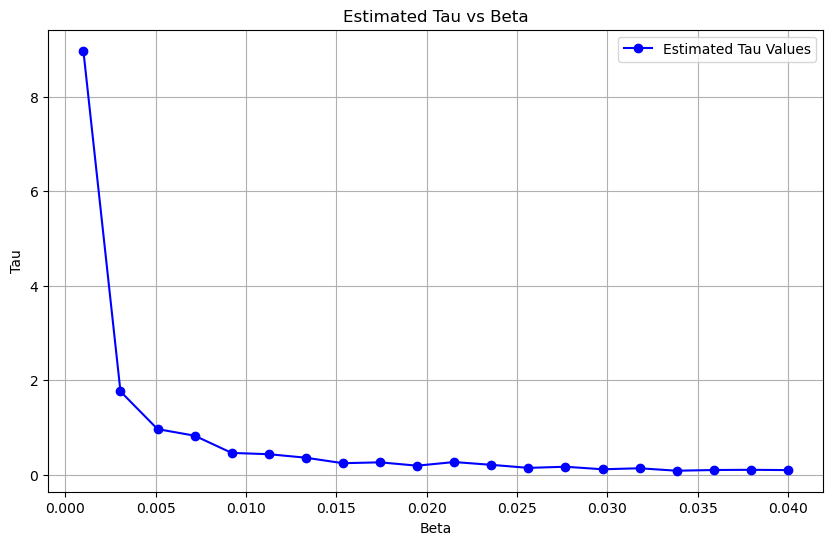

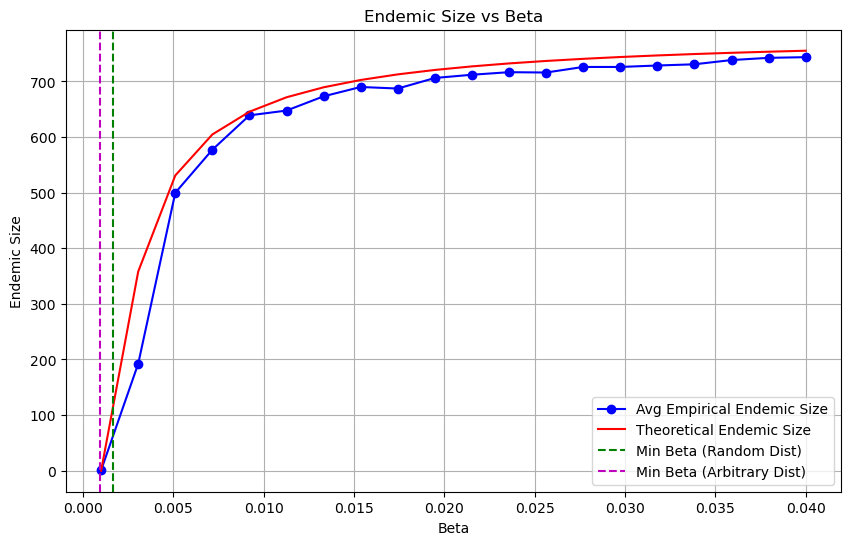

>>>>> Results for Part 2 <<<<<
Avg_taus = [8.98 1.77 0.97 0.83 0.47 0.44 0.36 0.25 0.27 0.2  0.27 0.21 0.15 0.17
 0.12 0.14 0.09 0.1  0.11 0.1 ]

Avg endemic size = [  1. 192. 500. 577. 639. 648. 673. 690. 687. 706. 712. 717. 716. 726.
 726. 729. 731. 738. 742. 744.]

Theo endemic size = [  0. 358. 531. 605. 646. 671. 689. 703. 713. 721. 727. 732. 737. 741.
 744. 747. 749. 751. 753. 755.]

Min beta for random distribution = 0.00167
Min beta for arbitrary distribution = 0.00095


In [102]:
# do not modify
### 2.1
G = load_flu_network()

betas, beta_runs = simulate_beta_sweep(G, 5, beta_samples=20)

avg_taus = extract_average_tau(beta_runs)
times = np.linspace(0, 2.2, 100)

plot_beta_tau_curves(betas, avg_taus, t=times)

### 2.2
avg_endemic_sizes = extract_average_endemic_size(beta_runs)

(
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
) = calculate_theoretical_endemic(G, betas)

compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
)

# print results
print(">>>>> Results for Part 2 <<<<<")
with np.printoptions(precision=2, suppress=True):
    print(f"Avg_taus = {np.array(avg_taus)}\n")

with np.printoptions(precision=0, suppress=True):
    print(f"Avg endemic size = {np.array(avg_endemic_sizes)}\n")
    print(f"Theo endemic size = {np.array(theoretical_endemics_sizes)}\n")

print(f"Min beta for random distribution = {rand_dist_min_beta:.5f}")
print(f"Min beta for arbitrary distribution = {arb_dist_min_beta:.5f}")

### 2.3 Written Response

Answer: 

## Part 3
### 3.1 

In [105]:
from concurrent.futures import ThreadPoolExecutor

def sweep_initial_infected(G, tmax=10, beta=0.01, mu=0.5):
    """
    Optimized function to compute tau values for each node as the initial infected.
    Uses parallel execution to speed up the process.

    Inputs:
        G : nx.Graph
        tmax : int
        beta : float
        mu : float

    Returns:
        taus : list[float]
            List of tau values corresponding to the `nodes` return value below.
        nodes : list[int]
    """

    def process_node(node):
        """Helper function to run the simulation for a single node."""
        runs = simulate_outbreak(G, 1, initial_infected=node, tmax=tmax, beta=beta, mu=mu)
        if runs:
            tau = get_exponent(runs[0])
            if 0 < tau < 1e6:  # Prevent numerical instability
                return node, tau
        return None

    taus = []
    nodes = []

    # Run in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust based on CPU cores
        results = list(executor.map(process_node, G.nodes()))

    for result in results:
        if result:
            node, tau = result
            nodes.append(node)
            taus.append(tau)

    return taus, nodes


def compute_centrality(G, nodes):
    """
    Optimized centrality computation using precomputed dictionaries.

    Inputs:
        G : nx.Graph
        nodes : list[int]

    Returns:
        cent_dict : dict[list[float]]
    """
    degree = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=500)  # Reduce iterations
    except nx.NetworkXError:
        eigenvector = {n: 0 for n in nodes}  # Handle errors

    cent_dict = {
        "deg": [degree.get(n, 0) for n in nodes],
        "clo": [closeness.get(n, 0) for n in nodes],
        "bet": [betweenness.get(n, 0) for n in nodes],
        "eig": [eigenvector.get(n, 0) for n in nodes],
    }
    
    return cent_dict


### 3.2

In [107]:
def calculate_person_correlation(taus, cent_dict):
    """
    Computes the Pearson correlation coefficient between tau values and centrality metrics.
    
    Inputs:
        taus : list[float]
        cent_dict : dict[list[float]]
            Dictionary containing centrality metrics computed from `compute_centrality`.
    
    Returns:
        r_dict : dict[tuple[float, float]]
            Dictionary where keys are 'deg', 'clo', 'bet', and 'eig', and values
            are tuples containing (Pearson correlation coefficient, p-value).
    """
    r_dict = {}
    
    for key, values in cent_dict.items():
        if len(values) == len(taus) and len(taus) > 1:  # Ensure valid input length
            try:
                r_dict[key] = scipy.stats.pearsonr(taus, values)
            except ValueError:
                r_dict[key] = (0.0, 1.0)  # Handle computation errors
        else:
            r_dict[key] = (0.0, 1.0)  # Assign neutral correlation if lengths don't match
    
    return r_dict

def plot_centrality_vs_tau(taus, cent_dict, r_dict, save=False):
    """
    Plots tau values against centrality metrics.
    
    Inputs:
        taus : list[float]
            List of tau values corresponding to each node.
        cent_dict : dict[list[float]]
            Centrality metrics computed from `compute_centrality`.
        r_dict : dict[tuple[float, float]]
            Pearson correlation coefficients computed from `calculate_pearson_correlation`.
        save : bool
            Whether to save the figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ["deg", "clo", "bet", "eig"]
    titles = ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
    
    for ax, metric, title in zip(axes.flatten(), metrics, titles):
        ax.scatter(cent_dict[metric], taus, alpha=0.5)
        ax.set_xlabel(f"{title}")
        ax.set_ylabel("Tau")
        ax.set_title(f"{title} (r={r_dict[metric][0]:.2f}, p={r_dict[metric][1]:.4f})")
    
    plt.tight_layout()
    
    if save:
        plt.savefig("3_2.png")
    
    plt.show()


### 3.3

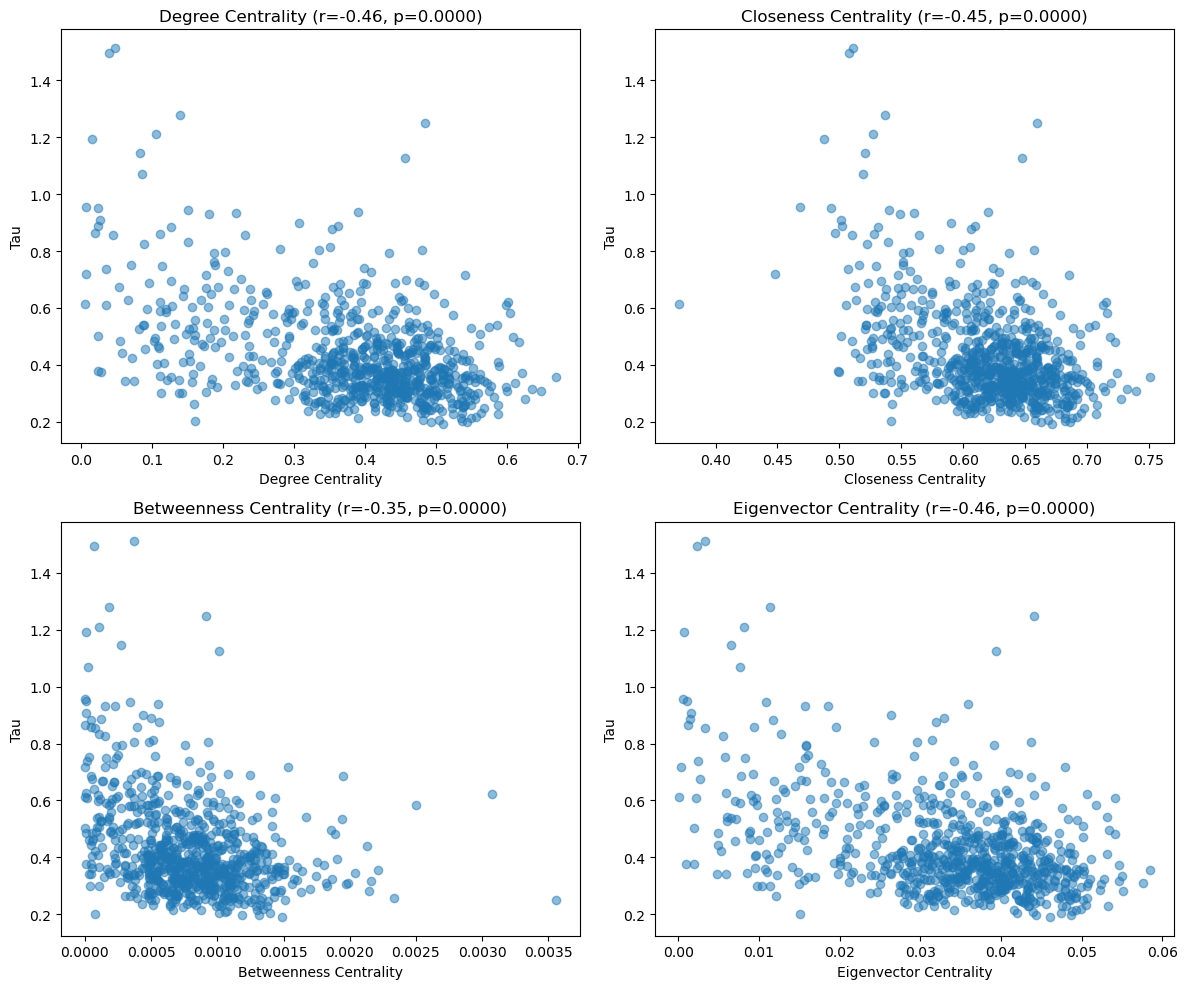

Number of included nodes = 788
bet = -0.3478, pvalue = 0.0000
clo = -0.4467, pvalue = 0.0000
deg = -0.4622, pvalue = 0.0000
eig = -0.4608, pvalue = 0.0000
Elapsed time =  3.34 minutes


In [109]:
# do not modify
start_time = time.time()
G = load_flu_network()

taus, nodes = sweep_initial_infected(G)
cent_dict = compute_centrality(G, nodes)

r_dict = calculate_person_correlation(taus, cent_dict)
plot_centrality_vs_tau(taus, cent_dict, r_dict)

print(f"Number of included nodes = {len(nodes)}")
for k in sorted(r_dict):
    coeff, pvalue = r_dict[k]
    print(f"{k} = {coeff:.4f}, pvalue = {pvalue:.4f}")

# We don't grade by how long it tak es. This is purly informational.
seconds_elapsed = time.time() - start_time
print(f"Elapsed time = {seconds_elapsed/60 : .2f} minutes")

### 3.3 Written Response

Answer:

## Part 4: Knowledge Question [5 Points]

Answer:


(You can do this proof as markdown here or upload an image of the proof on paper. If you upload an image make sure to include the image file with your submission)